In [46]:
import rawpy
import numpy as np
import cv2
from matplotlib import pyplot as plt

def process_huawei_dng(dng_path, output_path='output.jpg'):
    """
    处理华为DNG文件的完整流程
    参数：
        dng_path: 输入的DNG文件路径
        output_path: 输出图片路径（默认output.jpg）
    """
    try:
        # 1. 读取DNG文件
        with rawpy.imread(dng_path) as raw:
            # 2. 提取元数据
            metadata = raw.metadata
            white_level = raw.white_level
            camera_whitebalance = raw.camera_whitebalance
            
            # 华为专用参数（部分机型需要手动设置）
            huawei_color_matrix = np.array([
                [1.6863, -0.3535, -0.3328],
                [-0.3067, 1.6531, -0.3464],
                [-0.1643, -0.6234, 1.7877]
            ])  # P40 Pro示例矩阵

            # 3. 去马赛克处理
            rgb = raw.postprocess(
                demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,  # 自适应同态滤波
                use_camera_wb=True,       # 使用相机白平衡
                user_wb=camera_whitebalance,
                output_color=rawpy.ColorSpace.raw, # 保持原始颜色空间
                no_auto_bright=True       # 禁用自动亮度
            )

            # 4. 白平衡校正（手动增强）
            # 提取AsShotNeutral值（华为元数据中的白平衡系数）
            as_shot_neutral = metadata.get('as_shot_neutral', [1.0, 1.0, 1.0])
            if len(as_shot_neutral) == 3:
                rgb = rgb * np.array(as_shot_neutral).reshape(1, 1, 3)

            # 5. 应用华为颜色矩阵
            rgb_linear = np.dot(rgb, huawei_color_matrix.T)

            # 6. Gamma校正（sRGB曲线）
            rgb_gamma = np.where(
                rgb_linear <= 0.0031308,
                12.92 * rgb_linear,
                1.055 * (rgb_linear ** (1/2.4)) - 0.055
            )

            # 7. 值裁剪和归一化
            rgb_clipped = np.clip(rgb_gamma * 255, 0, 255).astype(np.uint8)

            # 8. 后处理（对比度增强）
            lab = cv2.cvtColor(rgb_clipped, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            enhanced = cv2.merge((l, a, b))
            final = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

            # 9. 保存结果
            cv2.imwrite(output_path, cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
            print(f"处理成功，结果已保存至：{output_path}")

            # 可选：显示图片
            plt.imshow(final)
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"处理失败：{str(e)}")

if __name__ == '__main__':
    process_huawei_dng('dng/sensor_raw_1739938190795.dng')

处理失败：'rawpy._rawpy.RawPy' object has no attribute 'metadata'


In [1]:
import rawpy
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imageio
from PIL import Image

[[ 80 111  88 ...  96  76  94]
 [108  84 114 ...  75  92  76]
 [ 79 101  81 ...  99  82  93]
 ...
 [115 113 120 ... 140 173 148]
 [ 96 133  87 ... 174 111 171]
 [129 107 143 ... 140 160 144]]
CFA pattern: RGBG


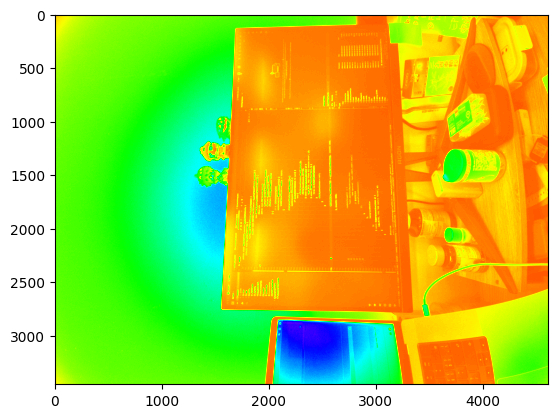

In [58]:
dng_path = 'dng/sensor_raw_1739938190795.dng'

img_dng = rawpy.imread(dng_path)
pattern = img_dng.color_desc
img_dng_dng = img_dng.raw_image.copy()
img_dng_dng = np.array(img_dng_dng)
print(img_dng_dng)

print(f"CFA pattern: {pattern.decode('ascii')}")
plt.imshow(img_dng_dng, cmap='hsv')

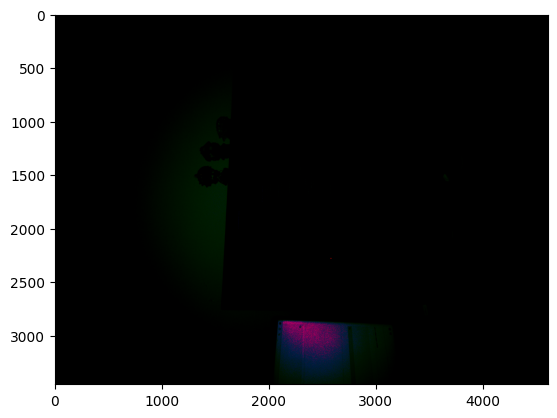

In [ ]:
dng_path = 'dng/sensor_raw_1739938190795.dng'

# 读取DNG文件
with rawpy.imread(dng_path) as raw:
    # 关键处理步骤：去马赛克和色彩转换
    rgb_image = raw.postprocess(
        demosaic_algorithm=rawpy.DemosaicAlgorithm.AHD,  # 自适应同质性导向算法[7](@ref)
        use_camera_wb=True,          # 强制使用相机白平衡[6](@ref)
        output_color=rawpy.ColorSpace.Adobe,  # 匹配华为色彩配置[7](@ref)
        no_auto_bright=True,         # 禁用自动亮度防止过曝
        gamma=(2.2, 4.5),            # 优化伽马曲线
        exp_shift=0.7                # 降低高光区域曝光（缓解偏绿）[4](@ref)
    )

rgb_image = Image.fromarray(rgb_image)
    
# 显示处理后的照片
plt.imshow(rgb_image)



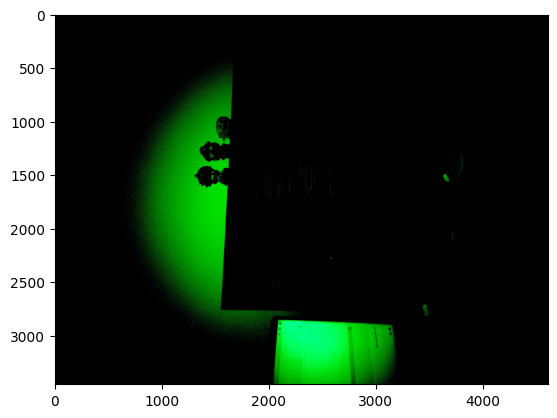

In [4]:
dng_path = 'dng/sensor_raw_1739938190795.dng'

img_dng = rawpy.imread(dng_path)
default_output = img_dng.raw_image
output_image = img_dng.postprocess()
output_image = Image.fromarray(output_image)
plt.imshow(output_image)

/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_35988/1776183858.py:67: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.savefig('output.pdf')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_35988/1776183858.py:67: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.savefig('output.pdf')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_35988/1776183858.py:67: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.savefig('output.pdf')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_35988/1776183858.py:67: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.savefig('output.pdf')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_35988/1776183858.py:67: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.savefig

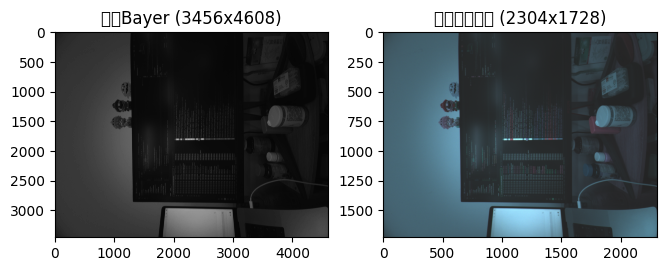

In [27]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt

def quad_binning(dng_path, cfa_pattern='RGBG'):
    """
    四合一像素合并，解决颜色偏差问题
    参数说明：
    cfa_pattern - CFA排列模式，支持'RGBG'/'RGGB'/'BGGR'等
    """
    with rawpy.imread(dng_path) as raw:
        # 获取原始数据和白平衡系数
        bayer = raw.raw_image_visible.astype(np.float32)
        wb = raw.camera_whitebalance  # 获取相机白平衡系数
        
        # 定义各通道在2x2块中的位置映射
        cfa_map = {
            'RGBG': {
                'R': [(0,0)],
                'G': [(0,1), (1,1)],
                'B': [(1,0)]
            }
        }
        
        # 校验尺寸并裁剪
        h, w = bayer.shape
        bayer = bayer[:h//2*2, :w//2*2]
        new_h, new_w = h//2, w//2
        
        # 初始化输出数组
        rgb = np.zeros((new_h, new_w, 3), dtype=np.float32)
        
        # 预处理：应用白平衡
        # for channel, positions in cfa_map[cfa_pattern].items():
        #     for (dx, dy) in positions:
        #         if channel == 'R':
        #             bayer[dx::2, dy::2] *= wb[0]/wb[1]
        #         elif channel == 'B':
        #             bayer[dx::2, dy::2] *= wb[2]/wb[1]
        
        # 像素合并处理
        for i in range(new_h):
            for j in range(new_w):
                block = bayer[2*i:2*i+2, 2*j:2*j+2]
                
                # 分别计算各通道均值
                R = np.mean([block[x,y] for (x,y) in cfa_map[cfa_pattern]['R']])
                G = np.mean([block[x,y] for (x,y) in cfa_map[cfa_pattern]['G']])
                B = np.mean([block[x,y] for (x,y) in cfa_map[cfa_pattern]['B']])
                
                rgb[i,j] = [R, G, B]
        
        # 自适应归一化（保护高光）
        max_val = np.percentile(rgb, 99.9)
        rgb_norm = np.clip(rgb / max_val * 255, 0, 255).astype(np.uint8)
        
        # 结果可视化
        plt.figure(figsize=(12,6))
        plt.subplot(131)
        plt.imshow(bayer, cmap='gray')
        plt.title(f"原始Bayer ({h}x{w})")
        
        plt.subplot(132)
        plt.imshow(rgb_norm)
        plt.title(f"四合一降采样 ({new_w}x{new_h})")

        plt.savefig('output.pdf')
        plt.show()


quad_binning('dng/sensor_raw_1739933611742.dng', cfa_pattern='RGBG')

array([[[ 83,  53,  87],
        [ 86,  55,  92],
        [ 84,  51,  98],
        ...,
        [ 72,  34,  55],
        [ 72,  35,  53],
        [ 66,  35,  54]],

       [[ 81,  52,  94],
        [ 82,  53,  80],
        [ 84,  51,  85],
        ...,
        [ 72,  33,  59],
        [ 68,  34,  59],
        [ 71,  37,  55]],

       [[ 85,  49,  89],
        [ 89,  49,  85],
        [ 84,  48,  91],
        ...,
        [ 69,  33,  57],
        [ 74,  35,  57],
        [ 68,  35,  64]],

       ...,

       [[ 87,  53,  86],
        [ 83,  56,  95],
        [ 87,  52,  87],
        ...,
        [118,  66, 127],
        [ 90,  49,  95],
        [ 71,  39,  64]],

       [[ 84,  52,  95],
        [ 86,  53,  93],
        [ 85,  54,  90],
        ...,
        [108,  70, 141],
        [ 80,  43,  88],
        [ 68,  36,  66]],

       [[ 79,  53,  83],
        [ 89,  54,  91],
        [ 93,  54,  85],
        ...,
        [109,  65, 133],
        [ 85,  45,  87],
        [ 70,  39,  62]]

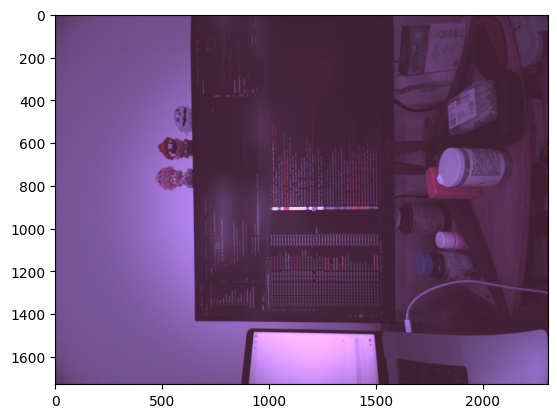

In [22]:
def optimized_quad_binning(dng_path,cfa_pattern='RGBG'):
    with rawpy.imread(dng_path) as raw:
        bayer = raw.raw_image_visible.astype(np.float32)
        wb = raw.camera_whitebalance
        
        # 白平衡预处理
        bayer[0::2, 0::2] *= wb[0]/wb[1]  # R
        bayer[1::2, 0::2] *= wb[2]/wb[1]  # B
        
        # 四合一降采样
        R = bayer[0::2, 0::2]
        B = bayer[1::2, 0::2]
        G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2
        
        # 堆叠通道
        rgb = np.dstack((R, G, B))
        
        # 归一化处理
        rgb = (rgb / np.percentile(rgb, 99) * 255).clip(0,255).astype(np.uint8)
        plt.imshow(rgb)
        return rgb
    
optimized_quad_binning('dng/sensor_raw_1739933611742.dng', cfa_pattern='RGBG')


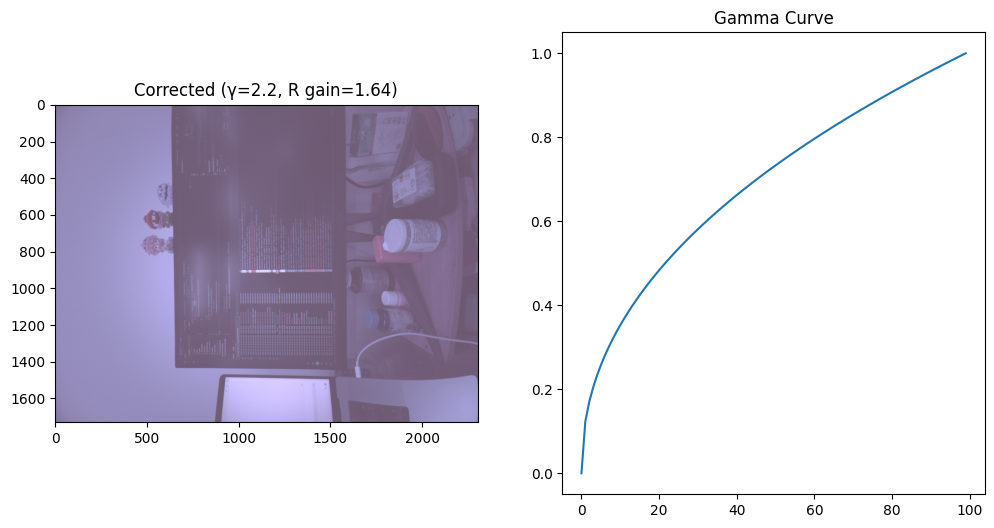

array([[[126, 115, 148],
        [129, 117, 152],
        [127, 114, 156],
        ...,
        [118,  95, 121],
        [118,  96, 119],
        [113,  96, 120]],

       [[125, 114, 153],
        [126, 115, 143],
        [127, 113, 146],
        ...,
        [118,  94, 125],
        [115,  95, 125],
        [117,  97, 121]],

       [[127, 111, 149],
        [130, 111, 146],
        [126, 111, 150],
        ...,
        [115,  93, 122],
        [119,  95, 123],
        [115,  95, 128]],

       ...,

       [[129, 115, 148],
        [126, 118, 154],
        [129, 114, 148],
        ...,
        [147, 127, 176],
        [131, 111, 154],
        [117, 101, 129]],

       [[127, 115, 154],
        [129, 115, 152],
        [128, 116, 150],
        ...,
        [143, 131, 184],
        [123, 105, 148],
        [115,  97, 130]],

       [[124, 115, 145],
        [130, 116, 151],
        [133, 116, 147],
        ...,
        [143, 126, 179],
        [127, 107, 148],
        [117, 101, 128]]

In [ ]:
def corrected_quad_binning(dng_path, cfa_pattern='RGBG', gamma=2.2, wb_factor=1.0):
    """
    改进版四合一处理，解决偏红问题
    参数：
    gamma - 伽马校正值（默认2.2）
    wb_factor - 红通道白平衡调节系数（默认1.0，<1减少红色，>1增加红色）
    """
    with rawpy.imread(dng_path) as raw:
        bayer = raw.raw_image_visible.astype(np.float32)
        wb = raw.camera_whitebalance
        
        # ================= 白平衡改进方案 =================
        # 方法1：使用自动白平衡（灰度世界假设）
        r_gain = bayer[0::2, 1::2].mean() / bayer[0::2, 0::2].mean()  # G/R
        b_gain = bayer[0::2, 1::2].mean() / bayer[1::2, 0::2].mean()  # G/B

        
        # 应用白平衡增益
        bayer[0::2, 0::2] *= r_gain  # R通道
        bayer[1::2, 0::2] *= b_gain  # B通道

        # ================= 四合一像素合并 =================
        R = bayer[0::2, 0::2]
        B = bayer[1::2, 0::2]
        G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2
        
        # ================= 颜色校正 =================
        rgb = np.dstack((R, G, B))
        
        # 可选：颜色矩阵校正（抑制红色）
        ccm = np.array([[0.9, 0.1, 0],  # 减少红色影响
                       [0, 1.0, 0],
                       [0, 0.1, 1.0]])
        rgb = np.dot(rgb, ccm.T)
        
        # ================= 伽马校正改进方案 =================
        # 线性归一化（保护高光）
        max_val = np.percentile(rgb, 99.5)
        rgb_norm = (rgb / max_val).clip(0, 1)
        
        # 应用伽马曲线
        rgb_gamma = np.power(rgb_norm, 1/gamma)
        
        # 转换为8bit
        rgb_8bit = (rgb_gamma * 255).astype(np.uint8)
        
        # ================= 可视化对比 =================
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.imshow(rgb_8bit)
        plt.title(f"Corrected (γ={gamma}, R gain={r_gain:.2f})")
        
        plt.subplot(122)
        plt.plot(np.power(np.linspace(0,1,100), 1/gamma))
        plt.title("Gamma Curve")
    

        plt.savefig('whole.pdf')
        plt.show()
        
        return rgb_8bit

# 使用示例（通过wb_factor减少红色）
corrected_quad_binning('dng/sensor_raw_1739933611742.dng', 
                      gamma=2.2, 
                      wb_factor=0.8)


In [ ]:
# def corrected_quad_binning(dng_path, cfa_pattern='RGBG', gamma=2.2, wb_factor=1.0):

with rawpy.imread(dng_path) as raw:
    bayer = raw.raw_image_visible.astype(np.float32)
    wb = raw.camera_whitebalance
    
    # ================= 白平衡改进方案 =================
    # 方法1：使用自动白平衡（灰度世界假设）
    r_gain = bayer[0::2, 1::2].mean() / bayer[0::2, 0::2].mean()  # G/R
    b_gain = bayer[0::2, 1::2].mean() / bayer[1::2, 0::2].mean()  # G/B

    
    # 应用白平衡增益
    bayer[0::2, 0::2] *= r_gain  # R通道
    bayer[1::2, 0::2] *= b_gain  # B通道

    # ================= 四合一像素合并 =================
    R = bayer[0::2, 0::2]
    B = bayer[1::2, 0::2]
    G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2
    
    # ================= 颜色校正 =================
    rgb = np.dstack((R, G, B))
    
    # 可选：颜色矩阵校正（抑制红色）
    ccm = np.array([[0.9, 0.1, 0],  # 减少红色影响
                    [0, 1.0, 0],
                    [0, 0.1, 1.0]])
    rgb = np.dot(rgb, ccm.T)
    
    # ================= 伽马校正改进方案 =================
    # 线性归一化（保护高光）
    max_val = np.percentile(rgb, 99.5)
    rgb_norm = (rgb / max_val).clip(0, 1)
    
    # 应用伽马曲线
    rgb_gamma = np.power(rgb_norm, 1/gamma)
    
    # 转换为8bit
    rgb_8bit = (rgb_gamma * 255).astype(np.uint8)
    
    # ================= 可视化对比 =================
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(rgb_8bit)
    plt.title(f"Corrected (γ={gamma}, R gain={r_gain:.2f})")
    
    plt.subplot(122)
    plt.plot(np.power(np.linspace(0,1,100), 1/gamma))
    plt.title("Gamma Curve")


    plt.savefig('whole.pdf')
    plt.show()
    
    return rgb_8bit

# 使用示例（通过wb_factor减少红色）
corrected_quad_binning('dng/sensor_raw_1739933611742.dng', 
                      gamma=2.2, 
                      wb_factor=0.8)


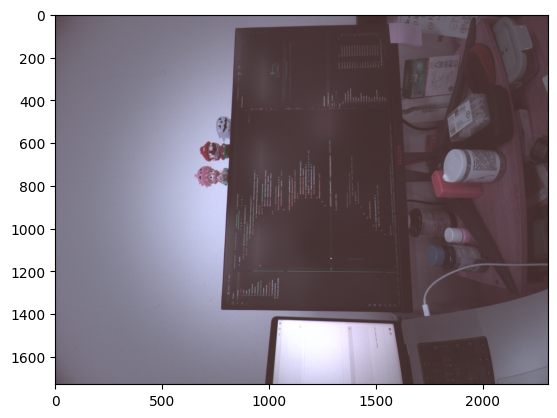

In [ ]:
with rawpy.imread(dng_path) as raw:
    bayer = raw.raw_image_visible.astype(np.float32)
    wb = raw.camera_whitebalance
    
    #灰度世界假设
    r_gain = bayer[0::2, 1::2].mean() / bayer[0::2, 0::2].mean()  # G/R
    b_gain = bayer[0::2, 1::2].mean() / bayer[1::2, 0::2].mean()  # G/B

    
    #白平衡增益
    bayer[0::2, 0::2] *= r_gain  # R通道
    bayer[1::2, 0::2] *= b_gain  # B通道

    R = bayer[0::2, 0::2]
    B = bayer[1::2, 0::2]
    G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2

    rgb = np.dstack((R, G, B))
    rgb_show = (rgb / np.percentile(rgb, 99) * 255).clip(0,255).astype(np.uint8)
    plt.imshow(rgb_show)


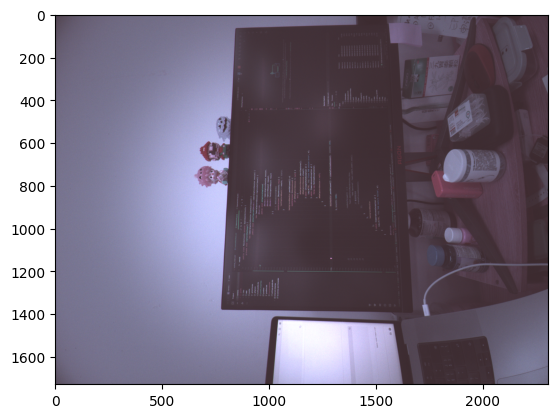

In [ ]:
#颜色校正矩阵
ccm = np.array([[0.9, 0.1, 0],  
                [0, 1.0, 0],
                [0, 0.1, 1.0]])
rgb = np.dot(rgb, ccm.T)
rgb_show = (rgb / np.percentile(rgb, 99) * 255).clip(0,255).astype(np.uint8)
plt.imshow(rgb_show)

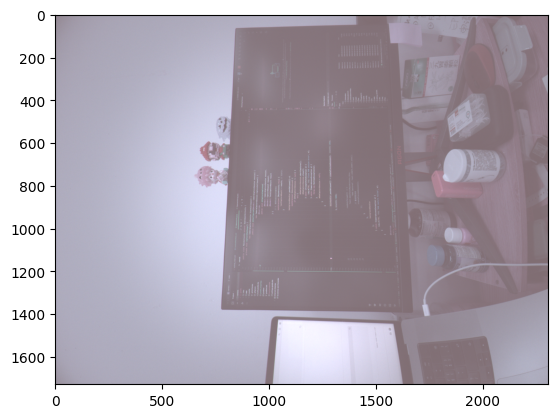

In [ ]:
gamma = 2.2

#线性化后再进行伽马校正
max_val = np.percentile(rgb, 99.5)
rgb_norm = (rgb / max_val).clip(0, 1)

rgb_gamma = np.power(rgb_norm, 1/gamma)

rgb_8bit = (rgb_gamma * 255).astype(np.uint8)
plt.imshow(rgb_8bit)

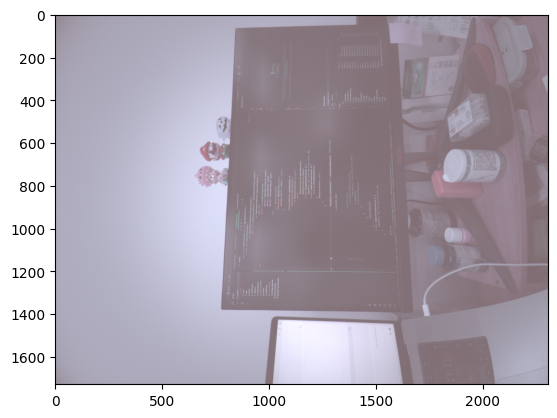

ValueError: The 'color' keyword argument must have one color per dataset, but 1 datasets and 3 colors were provided

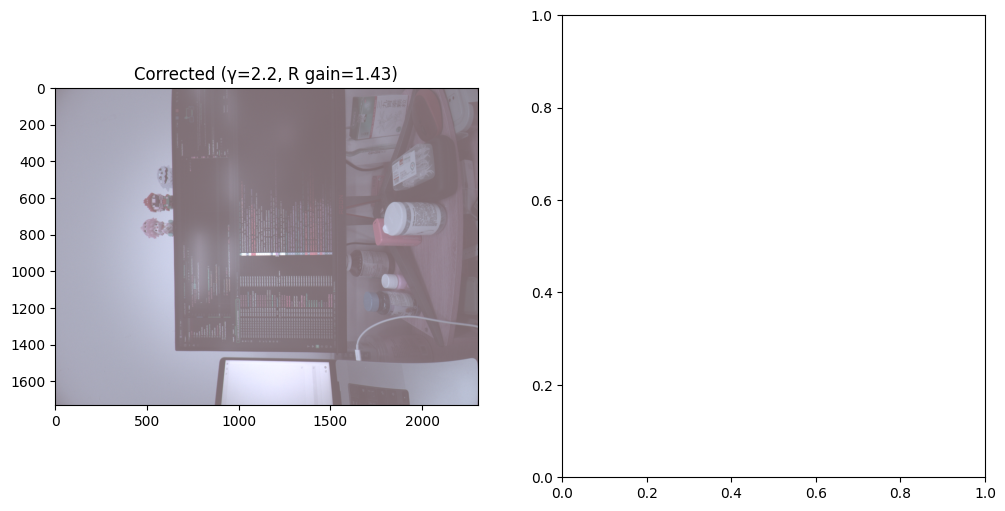

In [ ]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt

def quad_binning_with_wb_gamma(dng_path, gamma=2.2, wb_scale='auto'):
    """
    带白平衡和伽马校正的四合一像素合并
    参数：
    gamma - 伽马值（默认2.2）
    wb_scale - 白平衡基准通道：'camera'使用相机值，'auto'自动白平衡
    """
    with rawpy.imread(dng_path) as raw:
        # 获取原始数据
        bayer = raw.raw_image_visible.astype(np.float32)
        
        # 获取白平衡系数
        if wb_scale == 'camera':
            wb = np.array(raw.camera_whitebalance[:3])  # 取RGB三个通道
            wb /= wb[1]  # 以G通道为基准归一化
        elif wb_scale == 'auto':
            # 自动白平衡（灰度世界假设）
            wb = np.ones(3)
            wb[0] = bayer[0::2, 0::2].mean() / bayer[0::2, 1::2].mean()  # R/G
            wb[2] = bayer[1::2, 0::2].mean() / bayer[0::2, 1::2].mean()  # B/G

        # 应用白平衡
        bayer[0::2, 0::2] *= wb[0]  # R通道
        bayer[1::2, 0::2] *= wb[2]  # B通道
        
        # 四合一像素合并
        R = bayer[0::2, 0::2]      # 所有偶数行、偶数列的R
        B = bayer[1::2, 0::2]      # 所有奇数行、偶数列的B
        G = (bayer[0::2, 1::2] + bayer[1::2, 1::2]) / 2  # 两个G的平均
        
        # 堆叠通道并裁剪
        rgb = np.dstack((R, G, B))
        h, w = rgb.shape[:2]
        rgb = rgb[:h//2*2, :w//2*2]  # 确保偶数尺寸

        # 线性归一化（保护高光）
        max_val = np.percentile(rgb, 99.5)
        rgb_norm = rgb / max_val

        # 伽马校正
        rgb_gamma = np.power(rgb_norm.clip(0,1), 1/gamma)

        # 转换为8bit
        rgb_8bit = (rgb_gamma * 255).astype(np.uint8)

        # 可视化
        fig, ax = plt.subplots(2, 2, figsize=(12,10))
        ax[0,0].imshow(rgb_8bit)
        ax[0,0].set_title(f"Final Result (γ={gamma})")
        
        ax[0,1].imshow(rgb_norm[..., ::-1].clip(0,1))  # 显示原始线性RGB
        ax[0,1].set_title("Linear RGB")
        
        ax[1,0].plot(np.power(np.linspace(0,1,100), 1/gamma))
        ax[1,0].set_title("Gamma Curve")
        
        ax[1,1].hist(rgb_8bit.ravel(), bins=256, range=(0,255))
        ax[1,1].set_title("Histogram")
        plt.tight_layout()
        plt.show()

        return rgb_8bit

# 使用示例
result = quad_binning_with_wb_gamma('dng/sensor_raw_1739933611742.dng', gamma=2.2, wb_scale='camera')
